In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import Tensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import itertools
from tqdm import tqdm
import seaborn as sns

import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import snntorch.functional as SF
import snntorch.spikeplot as splt

from toolbox import and_generator, or_generator, xor_generator, forward_pass, set_seed

sns.set(style="darkgrid")


batch_size = 32
beta = 0.9
threshold = 0.9
surrogate_gradient = surrogate.fast_sigmoid()
adam_betas = (0.9, 0.999)
rates = (0.9, 0.1)
epochs = 30
timesteps = 10
seed = 1
learning_rate = 1e-1
seed = 3

def accuracy(spk_out, targets):
    with torch.no_grad():
        _, idx = spk_out.sum(dim=0).max(1)
        accuracy = ((targets == idx).float()).mean().item()
    return accuracy

def f1(spk_out, targets):
    from sklearn import metrics
    with torch.no_grad():
        _, idx = spk_out.sum(dim=0).max(1)
        f1 = metrics.f1_score(targets.cpu().numpy(), idx.cpu().numpy())
        return f1  

def predict_single(x, y, model, timesteps):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    spk, _ = forward_pass(model, torch.tensor([x, y], dtype=torch.float32).to(device), timesteps)
    _, idx = spk[:, None, :].sum(dim=0).max(1)
    return idx

def predict(data, model, timesteps):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if data.get_device() == -1:
        spk, _ = forward_pass(model, torch.tensor(data, dtype=torch.float32).to(device), timesteps)
    else:
        spk, _ = forward_pass(model, data, timesteps)
    _, idx = spk.sum(dim=0).max(1)
    return idx

def get_decision_surface(model, timesteps):
    xdata = np.linspace(0, 1, 10)
    ydata = np.linspace(0, 1, 10)
    X, Y, Z = [], [], []
    for x, y in np.array(list(itertools.product(xdata, ydata))):
        X.append(x)
        Y.append(y)
        Z.append(predict_single(x, y, model, timesteps).item())

    X = np.array(X).reshape(10, 10)
    Y = np.array(Y).reshape(10, 10)
    Z = np.array(Z).reshape(10, 10)
    return Z

def plot_decision_surface(decision_surface):
    xdata = np.linspace(0, 1, 10)
    ydata = np.linspace(0, 1, 10)
    X, Y = [], []
    for x, y in np.array(list(itertools.product(xdata, ydata))):
        X.append(x)
        Y.append(y)
    X = np.array(X).reshape(10, 10)
    Y = np.array(Y).reshape(10, 10)
    plt.contourf(X, Y, decision_surface, cmap='plasma')
    plt.title("Decision surface", y=1.05)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

def forward_pass(net, data, num_steps):
  spk_rec = []
  mem_hist = []
  utils.reset(net)

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      mem_hist.append(mem_out.cpu().detach().numpy())
      spk_rec.append(spk_out)

  return torch.stack(spk_rec), np.stack(mem_hist)

def train(
    batch_size = batch_size,
    beta = beta,
    threshold = threshold,
    adam_betas = adam_betas,
    rates = rates,
    epochs = epochs,
    timesteps = timesteps,
    learning_rate = learning_rate,
    seed = seed
):
    set_seed(seed=seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(and_generator(size=700), 32)
    test_loader = DataLoader(and_generator(size=300), 32)

    net = nn.Sequential(
        nn.Linear(2, 8),
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate_gradient, init_hidden=True),
        nn.Linear(8, 2),
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate_gradient, init_hidden=True, output=True)
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=adam_betas)
    correct_rate, incorrect_rate = rates
    loss_fn = SF.mse_count_loss(correct_rate=correct_rate, incorrect_rate=incorrect_rate)

    seed_dict = {
        "surfaces": [],
        "stats": {
            "loss": {
                "train": [],
                "test": []
            },
            "accuracy": {
                "train": [],
                "test": []
            },
            "f1": {
                "train": [],
                "test": []
            }
        }
    }
    for epoch in tqdm(range(epochs)):
        with torch.no_grad():
            decision_surface = get_decision_surface(net, timesteps)
            seed_dict["surfaces"].append(decision_surface)

        train_epoch_loss_val, train_epoch_acc_val, train_epoch_f1_val = 0, 0, 0
        for i, (data, targets) in enumerate(iter(train_loader)):
            data = data.to(device)
            targets = targets.squeeze().to(device)

            net.train()
            spk_rec, mem_hist = forward_pass(net, data, timesteps) # forward-pass
            loss_val = loss_fn(spk_rec, targets) # loss calculation
            optimizer.zero_grad() # null gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights
            # seed_dict["stats"]["loss"]["train"].append(loss_val.item())
            # seed_dict["stats"]["accuracy"]["train"].append(accuracy(spk_rec, targets))
            # seed_dict["stats"]["f1"]["train"].append(f1(spk_rec, targets))
            train_epoch_loss_val += loss_val.item()
            train_epoch_acc_val += accuracy(spk_rec, targets)
            train_epoch_f1_val += f1(spk_rec, targets)
        seed_dict["stats"]["loss"]["train"].append(train_epoch_loss_val/len(data))
        seed_dict["stats"]["accuracy"]["train"].append(train_epoch_acc_val/len(data))
        seed_dict["stats"]["f1"]["train"].append(train_epoch_f1_val/len(data))


        test_epoch_loss_val, test_epoch_acc_val, test_epoch_f1_val = 0, 0, 0
        for i, (data, targets) in enumerate(iter(test_loader)):
            data = data.to(device)
            targets = targets.squeeze().to(device)

            net.eval()
            spk_rec, mem_hist = forward_pass(net, data, timesteps)
            loss_val = loss_fn(spk_rec, targets)
            # seed_dict["stats"]["loss"]["test"].append(loss_val.item())
            # seed_dict["stats"]["accuracy"]["test"].append(accuracy(spk_rec, targets))
            # seed_dict["stats"]["f1"]["test"].append(f1(spk_rec, targets))
            test_epoch_loss_val += loss_val.item()
            test_epoch_acc_val += accuracy(spk_rec, targets)
            test_epoch_f1_val += f1(spk_rec, targets)
        seed_dict["stats"]["loss"]["test"].append(test_epoch_loss_val/len(data))
        seed_dict["stats"]["accuracy"]["test"].append(test_epoch_acc_val/len(data))
        seed_dict["stats"]["f1"]["test"].append(test_epoch_f1_val/len(data))
    return seed_dict

### Random seeds correlation

Random seed set as 1
Random seed set as 2
Random seed set as 3
Random seed set as 4
Random seed set as 5
Random seed set as 6
Random seed set as 7
Random seed set as 8
Random seed set as 9
Average corr 0.09889590253102688


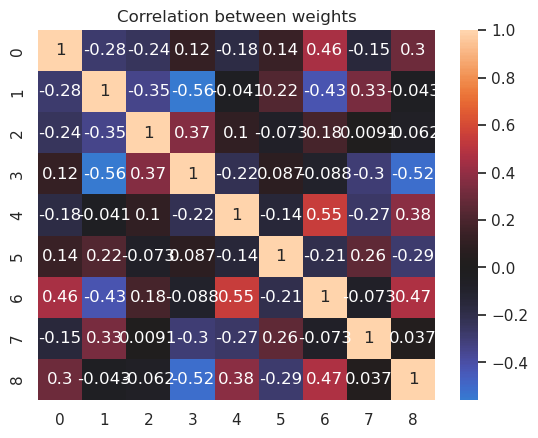

In [3]:
import torch.nn.init as init
import torch
import math

seqs = []
for seed in np.arange(1, 10, 1):
    set_seed(seed)
    weights = torch.empty(2, 8)
    init.kaiming_uniform_(weights, a=math.sqrt(5))
    seqs.append(weights.flatten())
sns.heatmap(np.corrcoef(np.vstack(seqs)), center=0, annot=True)
plt.title("Correlation between weights")
print("Average corr", np.mean(np.corrcoef(np.vstack(seqs))))

Random seed set as 1
Random seed set as 19
Random seed set as 4031
Random seed set as 90
Random seed set as 112
Random seed set as 373
Random seed set as 976
Random seed set as 9222
Random seed set as 17301
Average corr 0.1432308735627916


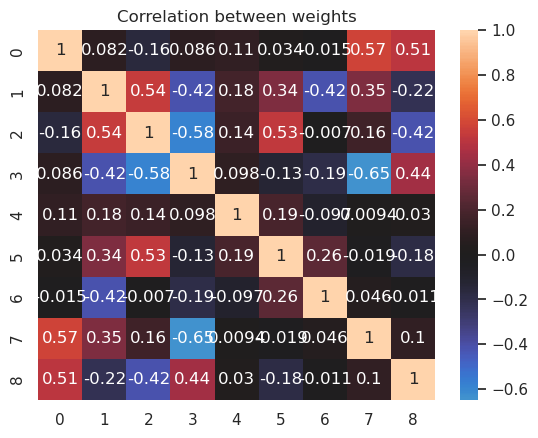

In [4]:
seqs = []
for seed in [1, 19, 4031, 90, 112, 373, 976, 9222, 17301]:
    set_seed(seed)
    weights = torch.empty(2, 8)
    init.kaiming_uniform_(weights, a=math.sqrt(5))
    seqs.append(weights.flatten())
sns.heatmap(np.corrcoef(np.vstack(seqs)), center=0, annot=True)
plt.title("Correlation between weights")
print("Average corr", np.mean(np.corrcoef(np.vstack(seqs))))

There doesn't seem to be any abnormal correlation between weights generated on subsequent seeds when compared to arbitraly random seeds.

In [5]:
import pickle

n_seeds = 50
seeds = np.arange(1, n_seeds, 1)

filename = "seeds_dict.pkl"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        seeds_dict = pickle.load(f)
    print("Loaded", filename)
else:
    seeds_dict = {}
    for seed in tqdm(seeds):
        seeds_dict[seed] = train(seed=seed)
    with open(filename, "wb") as f:
        pickle.dump(seeds_dict, f)

  0%|          | 0/49 [00:00<?, ?it/s]

Random seed set as 1


  2%|▏         | 1/49 [00:23<18:37, 23.29s/it]

Random seed set as 2


  4%|▍         | 2/49 [00:44<17:29, 22.34s/it]

Random seed set as 3


  6%|▌         | 3/49 [01:06<16:55, 22.08s/it]

Random seed set as 4


  8%|▊         | 4/49 [01:28<16:29, 21.99s/it]

Random seed set as 5


 10%|█         | 5/49 [01:50<16:05, 21.94s/it]

Random seed set as 6


 12%|█▏        | 6/49 [02:12<15:43, 21.94s/it]

Random seed set as 7


 14%|█▍        | 7/49 [02:34<15:21, 21.93s/it]

Random seed set as 8


 16%|█▋        | 8/49 [02:56<14:59, 21.93s/it]

Random seed set as 9


 18%|█▊        | 9/49 [03:18<14:39, 21.98s/it]

Random seed set as 10


 20%|██        | 10/49 [03:40<14:17, 21.99s/it]

Random seed set as 11


 22%|██▏       | 11/49 [04:01<13:50, 21.87s/it]

Random seed set as 12


 24%|██▍       | 12/49 [04:23<13:27, 21.82s/it]

Random seed set as 13


 27%|██▋       | 13/49 [04:45<13:02, 21.73s/it]

Random seed set as 14


 29%|██▊       | 14/49 [05:06<12:39, 21.69s/it]

Random seed set as 15


 31%|███       | 15/49 [05:28<12:18, 21.73s/it]

Random seed set as 16


 33%|███▎      | 16/49 [05:50<12:02, 21.90s/it]

Random seed set as 17


 35%|███▍      | 17/49 [06:12<11:42, 21.95s/it]

Random seed set as 18


 37%|███▋      | 18/49 [06:34<11:17, 21.86s/it]

Random seed set as 19


 39%|███▉      | 19/49 [06:56<10:54, 21.81s/it]

Random seed set as 20


 41%|████      | 20/49 [07:18<10:32, 21.79s/it]

Random seed set as 21


 43%|████▎     | 21/49 [07:39<10:10, 21.81s/it]

Random seed set as 22


 45%|████▍     | 22/49 [08:01<09:49, 21.83s/it]

Random seed set as 23


 47%|████▋     | 23/49 [08:24<09:30, 21.95s/it]

Random seed set as 24


 49%|████▉     | 24/49 [08:46<09:11, 22.05s/it]

Random seed set as 25


 51%|█████     | 25/49 [09:08<08:51, 22.13s/it]

Random seed set as 26


 53%|█████▎    | 26/49 [09:30<08:30, 22.20s/it]

Random seed set as 27


 55%|█████▌    | 27/49 [09:53<08:09, 22.26s/it]

Random seed set as 28


 57%|█████▋    | 28/49 [10:15<07:48, 22.32s/it]

Random seed set as 29


 59%|█████▉    | 29/49 [10:38<07:29, 22.46s/it]

Random seed set as 30


 61%|██████    | 30/49 [11:00<07:05, 22.40s/it]

Random seed set as 31


 63%|██████▎   | 31/49 [11:23<06:42, 22.36s/it]

Random seed set as 32


 65%|██████▌   | 32/49 [11:45<06:20, 22.36s/it]

Random seed set as 33


 67%|██████▋   | 33/49 [12:07<05:57, 22.32s/it]

Random seed set as 34


 69%|██████▉   | 34/49 [12:30<05:35, 22.36s/it]

Random seed set as 35


 71%|███████▏  | 35/49 [12:52<05:12, 22.35s/it]

Random seed set as 36


 73%|███████▎  | 36/49 [13:14<04:50, 22.36s/it]

Random seed set as 37


 76%|███████▌  | 37/49 [13:37<04:28, 22.40s/it]

Random seed set as 38


 78%|███████▊  | 38/49 [13:59<04:06, 22.44s/it]

Random seed set as 39


 80%|███████▉  | 39/49 [14:22<03:45, 22.55s/it]

Random seed set as 40


 82%|████████▏ | 40/49 [14:45<03:23, 22.66s/it]

Random seed set as 41


 84%|████████▎ | 41/49 [15:08<03:01, 22.67s/it]

Random seed set as 42


 86%|████████▌ | 42/49 [15:31<02:39, 22.80s/it]

Random seed set as 43


 88%|████████▊ | 43/49 [15:54<02:17, 22.85s/it]

Random seed set as 44


 90%|████████▉ | 44/49 [16:17<01:54, 22.87s/it]

Random seed set as 45


 92%|█████████▏| 45/49 [16:40<01:32, 23.03s/it]

Random seed set as 46


 94%|█████████▍| 46/49 [17:04<01:09, 23.11s/it]

Random seed set as 47


 96%|█████████▌| 47/49 [17:27<00:46, 23.21s/it]

Random seed set as 48


/home/mikolaj/anaconda3/envs/lic2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/mikolaj/anaconda3/envs/lic2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/mikolaj/anaconda3/envs/lic2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", l

Random seed set as 49


100%|██████████| 49/49 [18:14<00:00, 22.33s/it]


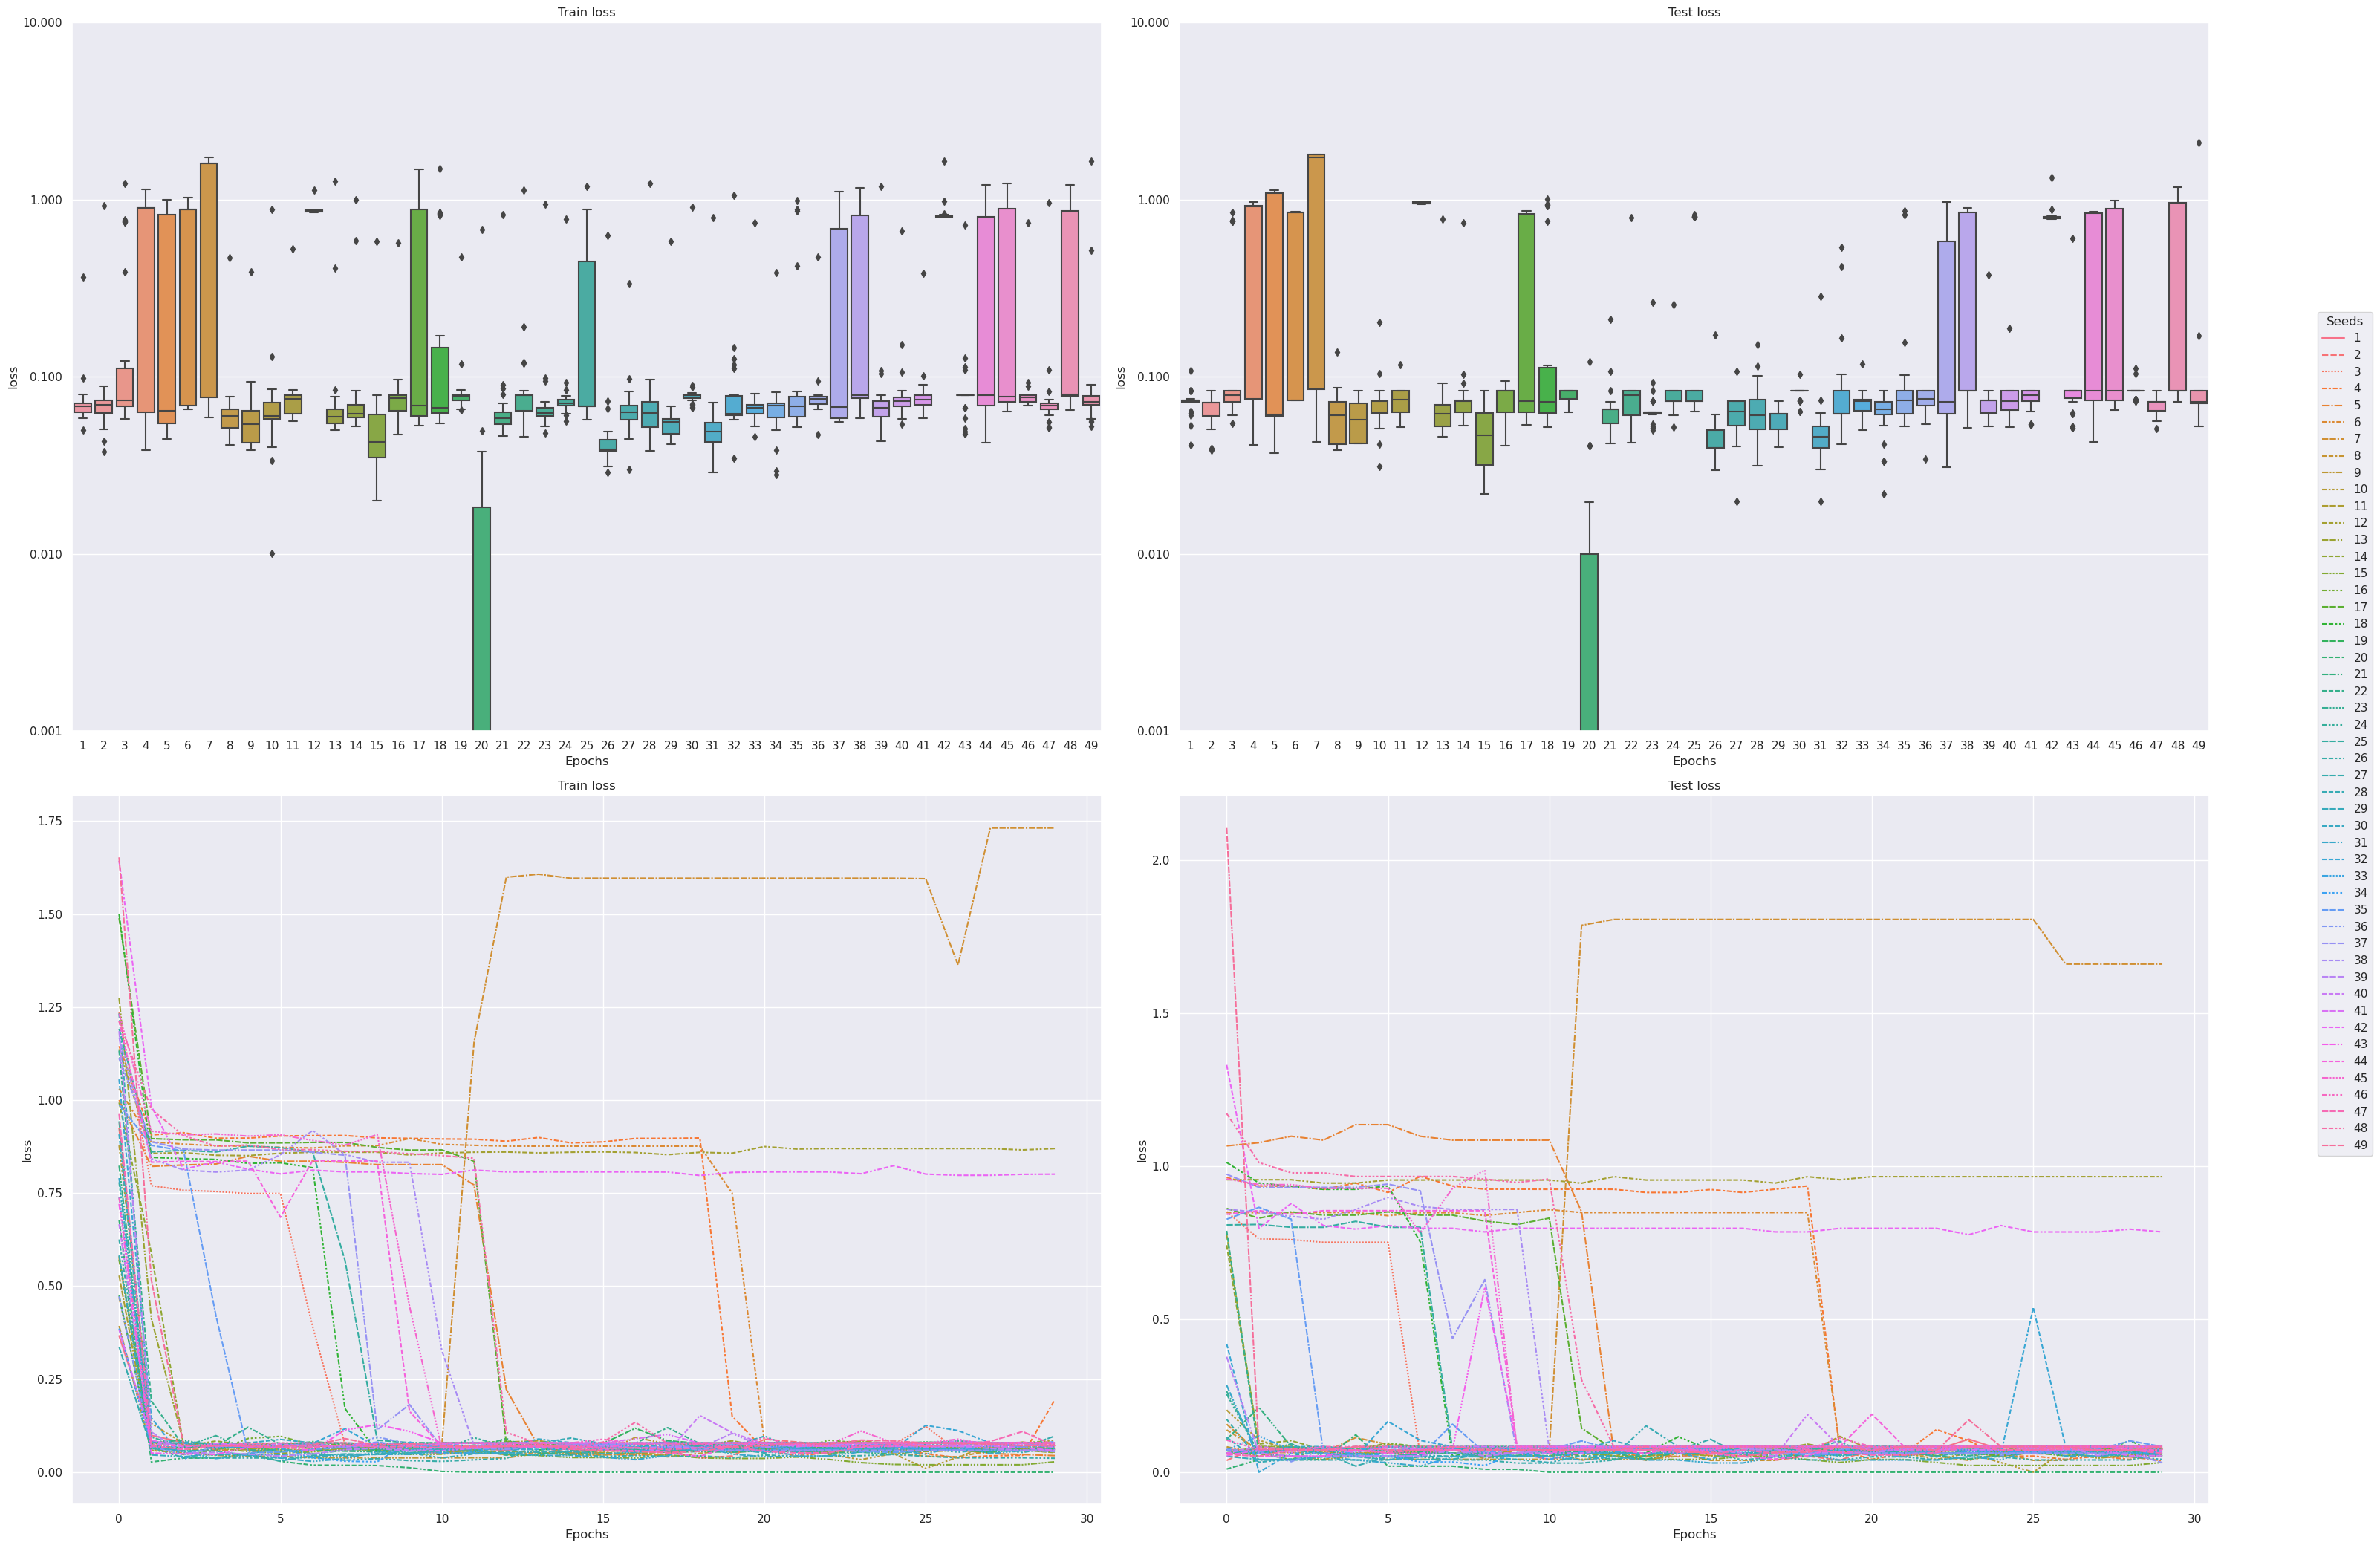

In [14]:
import matplotlib.ticker as ticker

stat = "loss"

all_train_loss = [seeds_dict[seed]["stats"][stat]["train"] for seed in seeds_dict]
all_test_loss = [seeds_dict[seed]["stats"][stat]["test"] for seed in seeds_dict]

fig, ax = plt.subplots(2, 2, figsize=(30, 21))
ax = ax.flatten()

ax0 = sns.boxplot(all_train_loss, ax=ax[0])
ax0.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Train {stat}", xticklabels=seeds)
ax1 = sns.boxplot(all_test_loss, ax=ax[1])
ax1.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Test {stat}", xticklabels=seeds)
ax2 = sns.lineplot(all_train_loss, ax=ax[2], legend=False)
ax2.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Train {stat}")
ax3 = sns.lineplot(all_test_loss, ax=ax[3], legend=True)
ax3.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Test {stat}")

handles, labels = ax3.get_legend_handles_labels()
ax3.get_legend().remove()
fig.legend(handles, np.arange(1, n_seeds, 1), loc='upper left', ncol=1, bbox_to_anchor=(1.04, 0.8), title="Seeds")


formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
for axis in [ax0, ax1]:
    axis.set_yscale('log')
    axis.set_yticks([0.001, 0.01, 0.1, 1, 10])
    axis.yaxis.set_major_formatter(formatter)
    axis.set_ylim([0.001, 10])
    axis.set_xticks = seeds

plt.tight_layout()
plt.show()

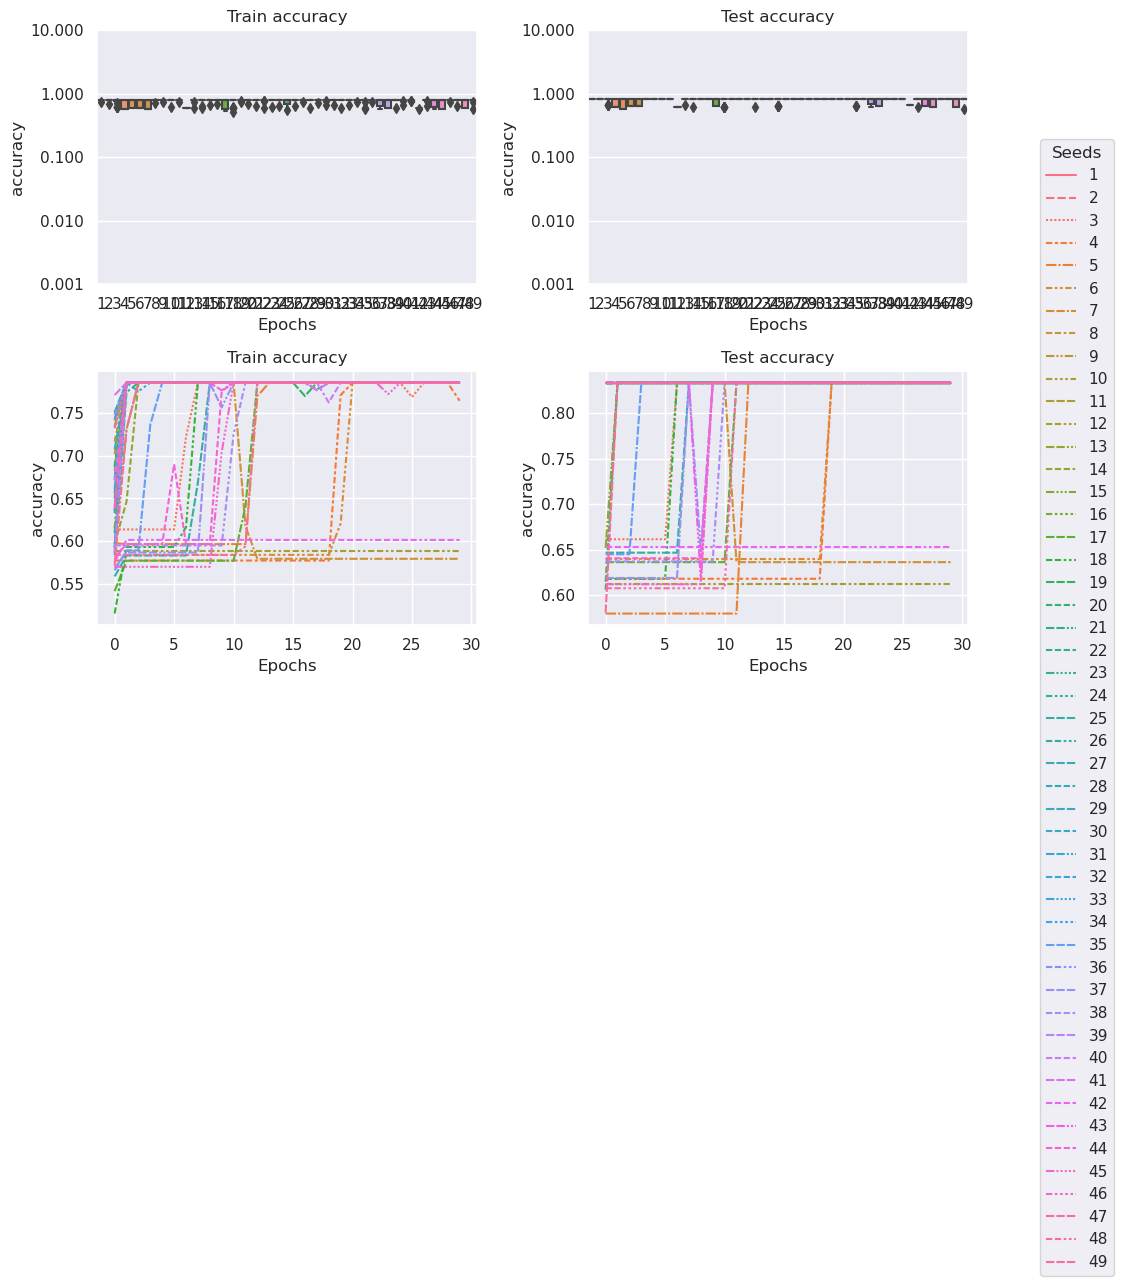

In [7]:
import matplotlib.ticker as ticker

stat = "accuracy"

all_train_loss = [seeds_dict[seed]["stats"][stat]["train"] for seed in seeds_dict]
all_test_loss = [seeds_dict[seed]["stats"][stat]["test"] for seed in seeds_dict]

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()

ax0 = sns.boxplot(all_train_loss, ax=ax[0])
ax0.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Train {stat}", xticklabels=seeds)
ax1 = sns.boxplot(all_test_loss, ax=ax[1])
ax1.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Test {stat}", xticklabels=seeds)
ax2 = sns.lineplot(all_train_loss, ax=ax[2], legend=False)
ax2.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Train {stat}")
ax3 = sns.lineplot(all_test_loss, ax=ax[3], legend=True)
ax3.set(xlabel="Epochs", ylabel=f"{stat}", title=f"Test {stat}")

handles, labels = ax3.get_legend_handles_labels()
ax3.get_legend().remove()
fig.legend(handles, np.arange(1, n_seeds, 1), loc='upper left', ncol=1, bbox_to_anchor=(1.04, 0.8), title="Seeds")


formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
for axis in [ax0, ax1]:
    axis.set_yscale('log')
    axis.set_yticks([0.001, 0.01, 0.1, 1, 10])
    axis.yaxis.set_major_formatter(formatter)
    axis.set_ylim([0.001, 10])
    axis.set_xticks = seeds

plt.tight_layout()
plt.show()

## TODO
- porownac wyniki i funkcje z githuba z tymi wynikami teraz
- moze chodzic o predict zmienione ```[:, None, :]```

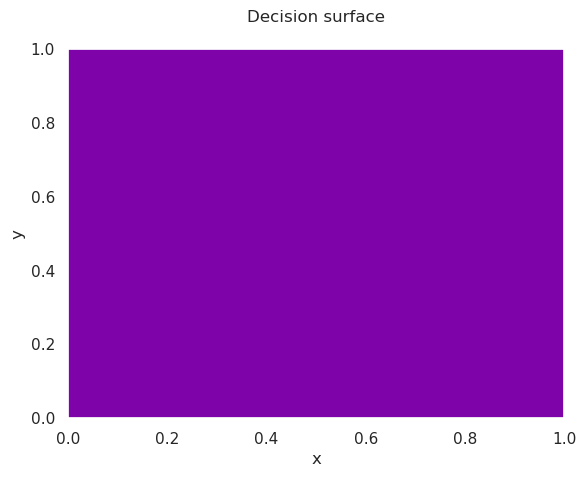

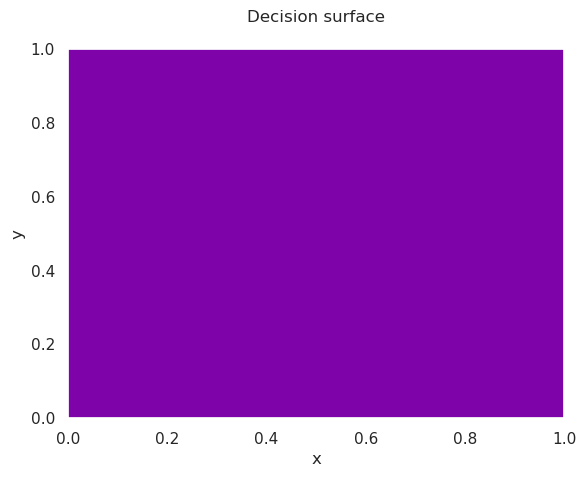

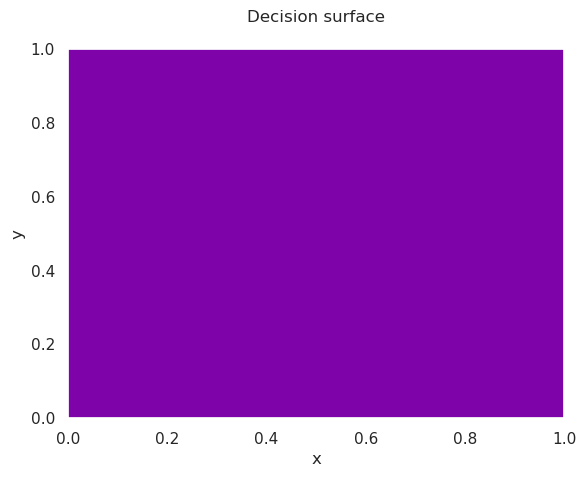

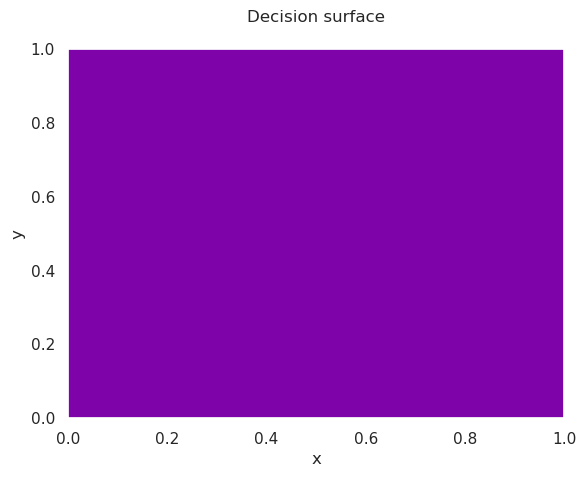

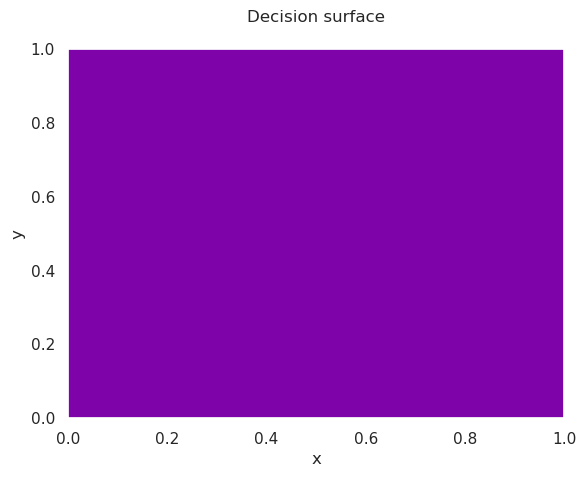

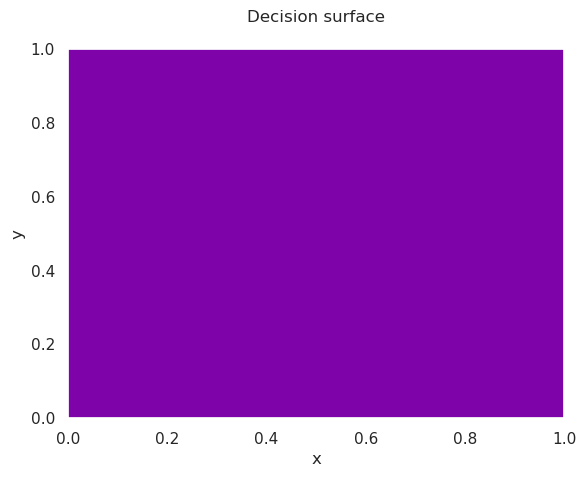

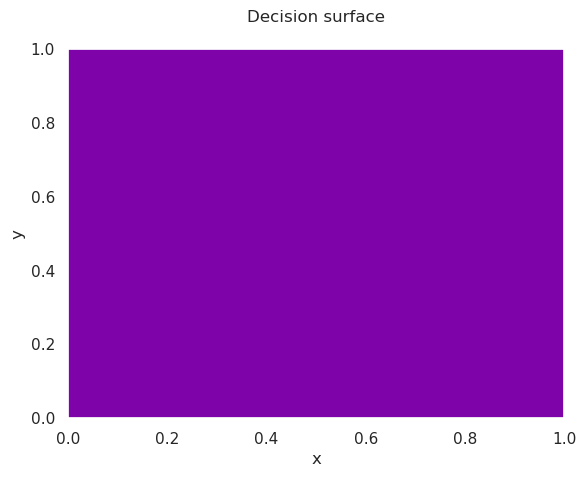

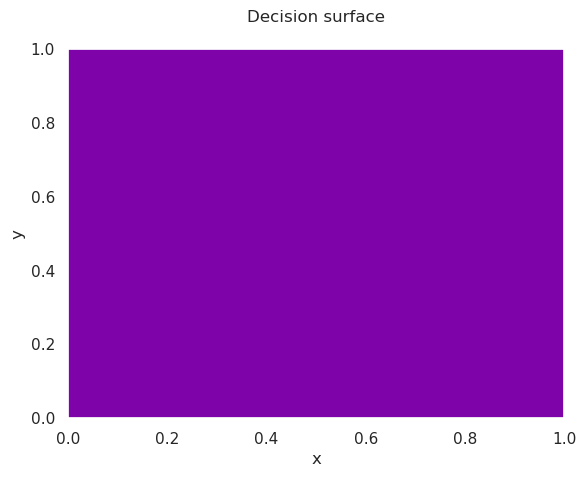

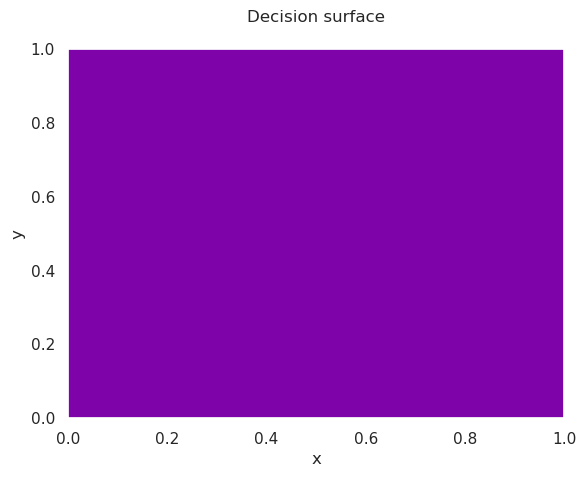

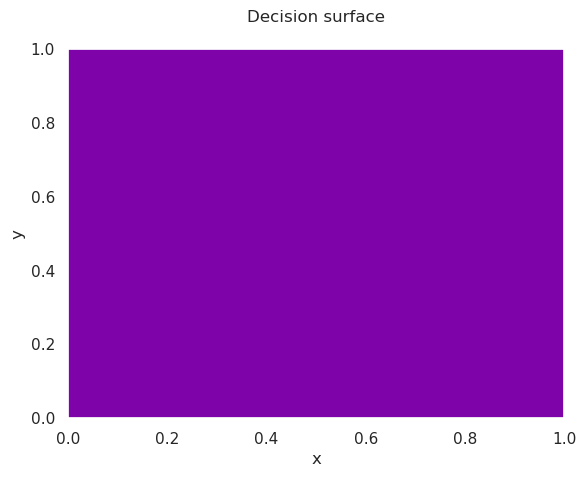

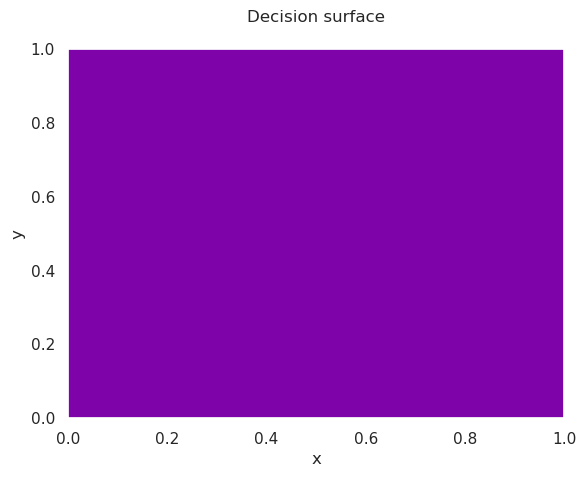

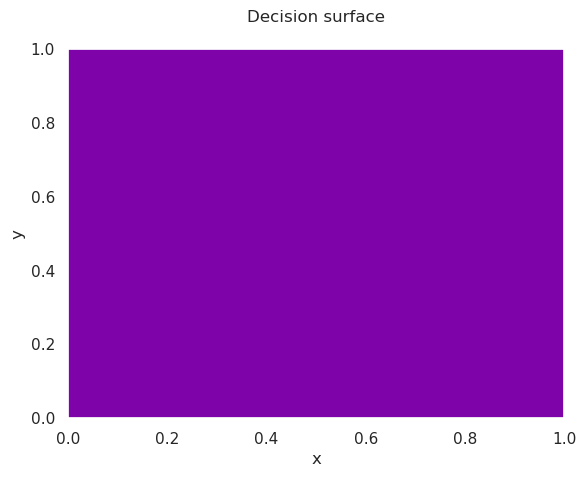

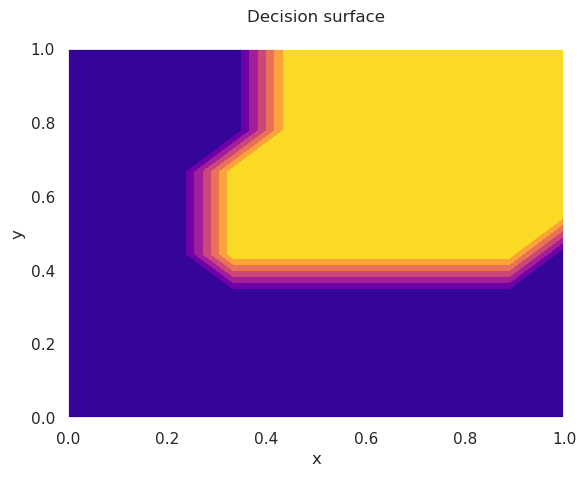

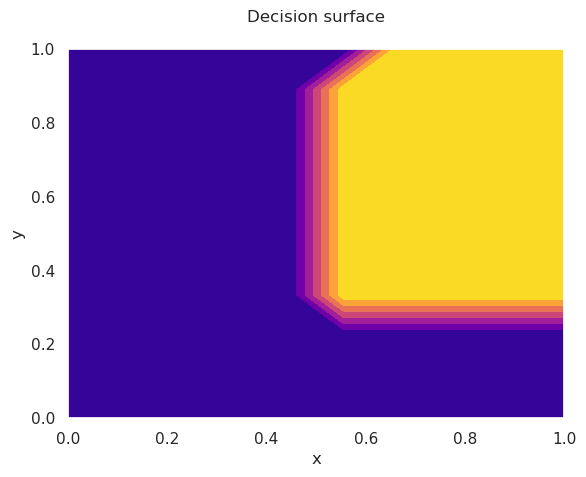

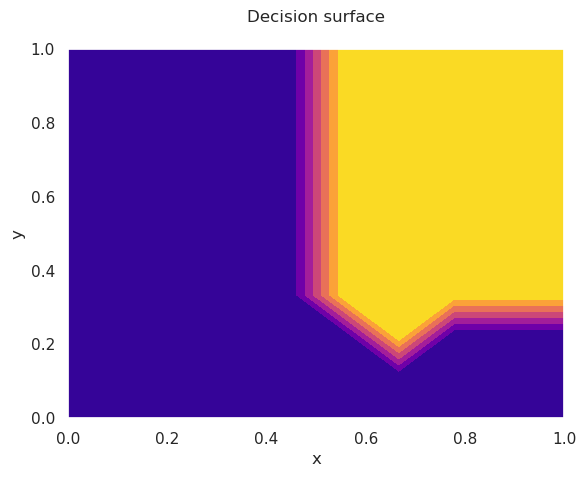

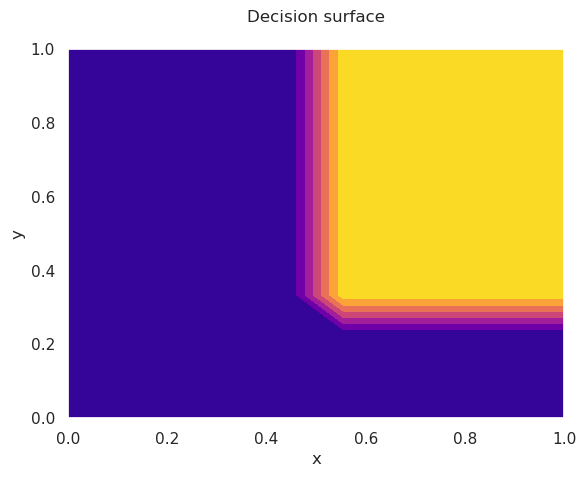

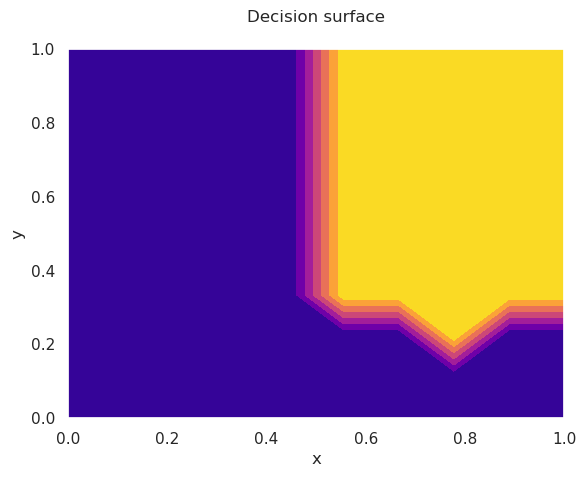

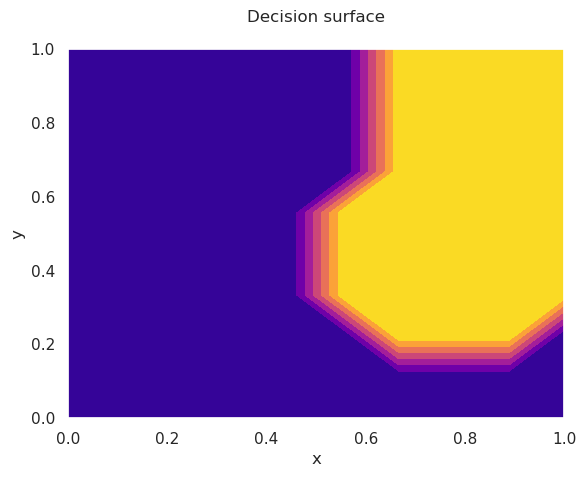

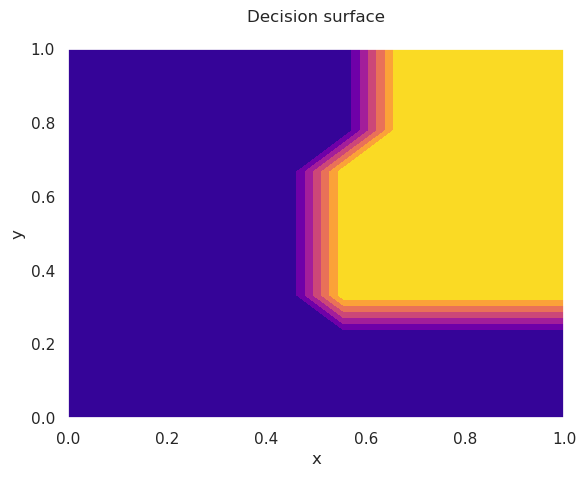

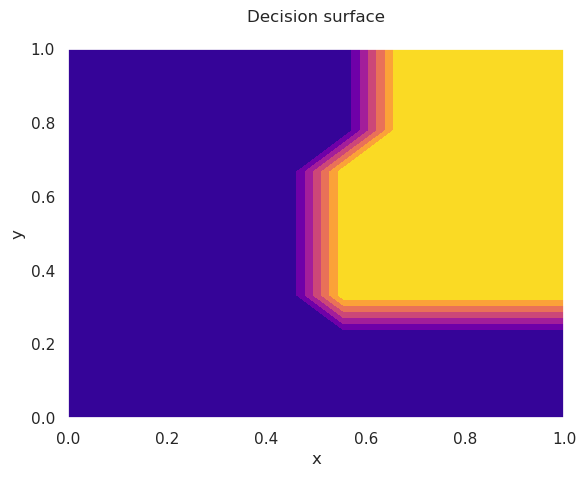

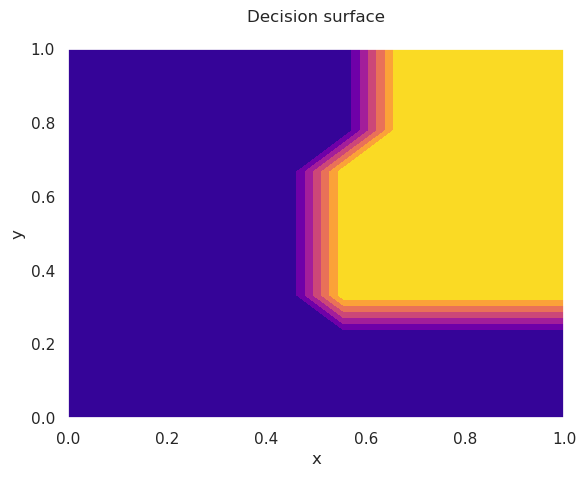

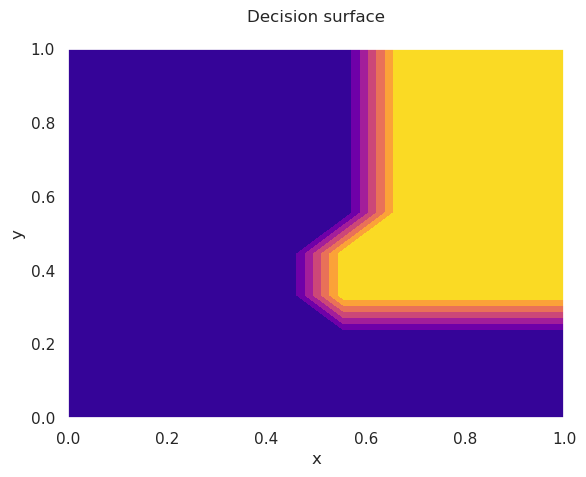

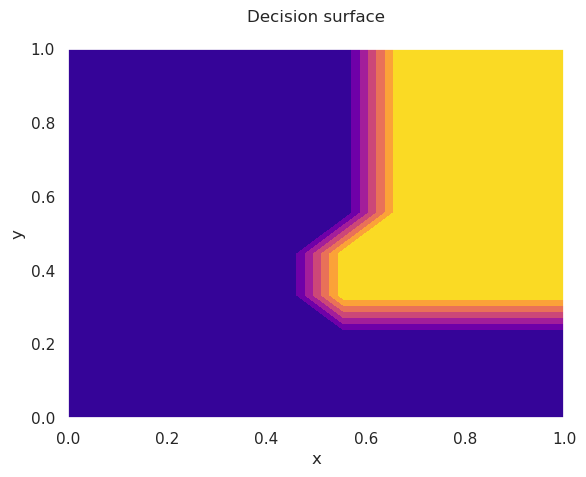

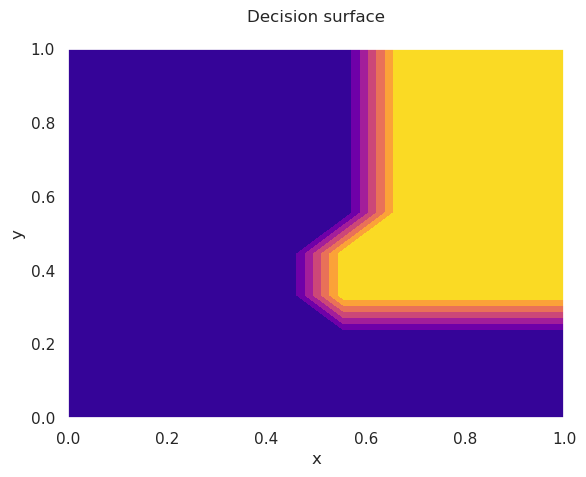

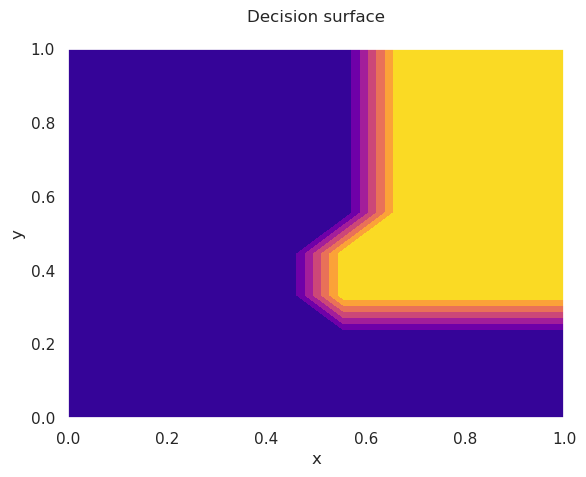

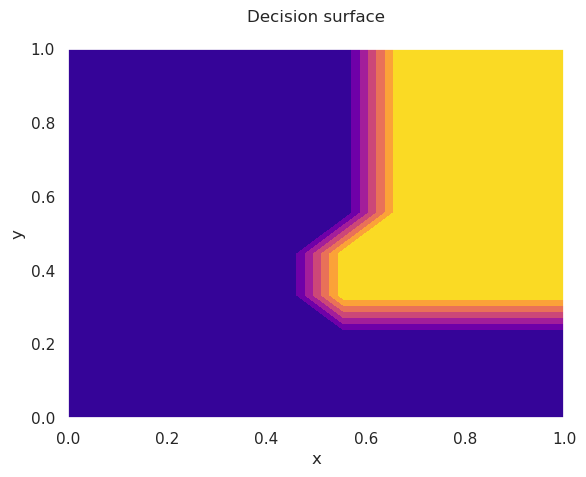

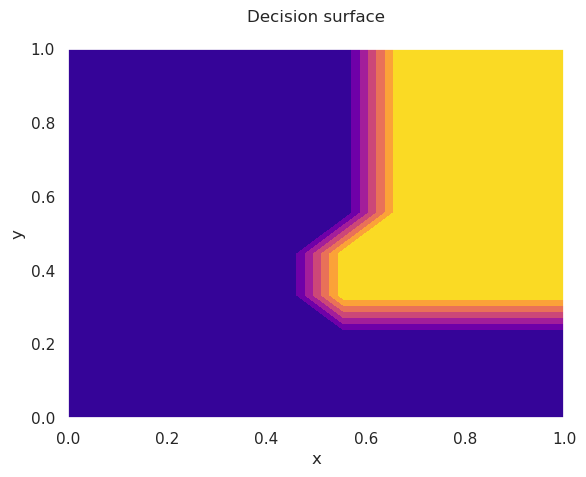

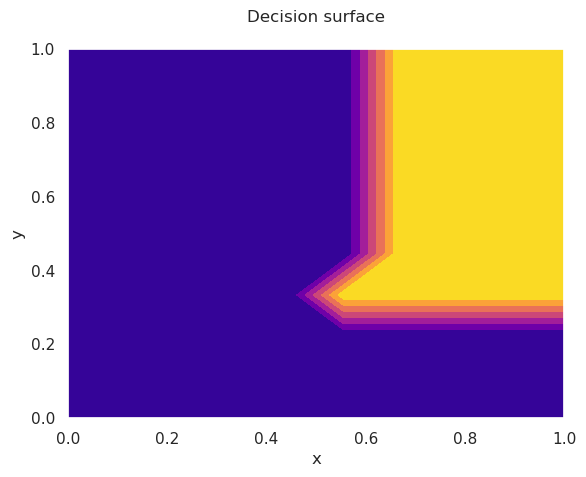

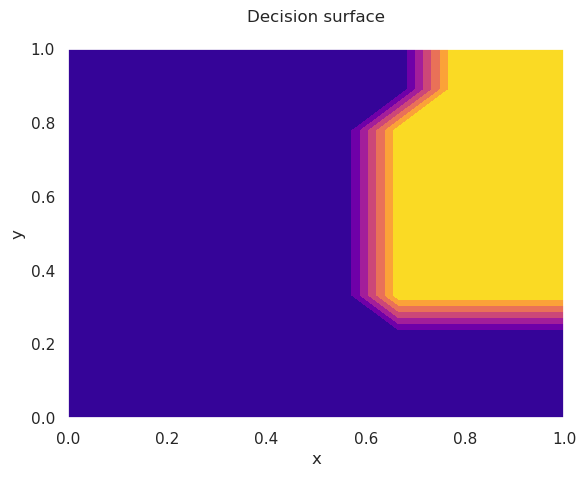

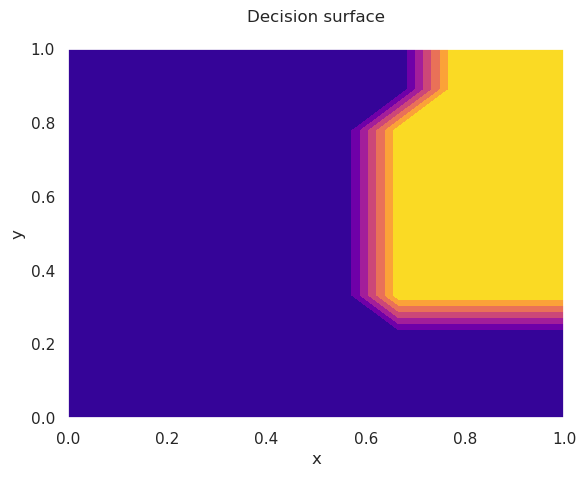

In [8]:
for z in seeds_dict[17]["surfaces"]:
    plot_decision_surface(z)